tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


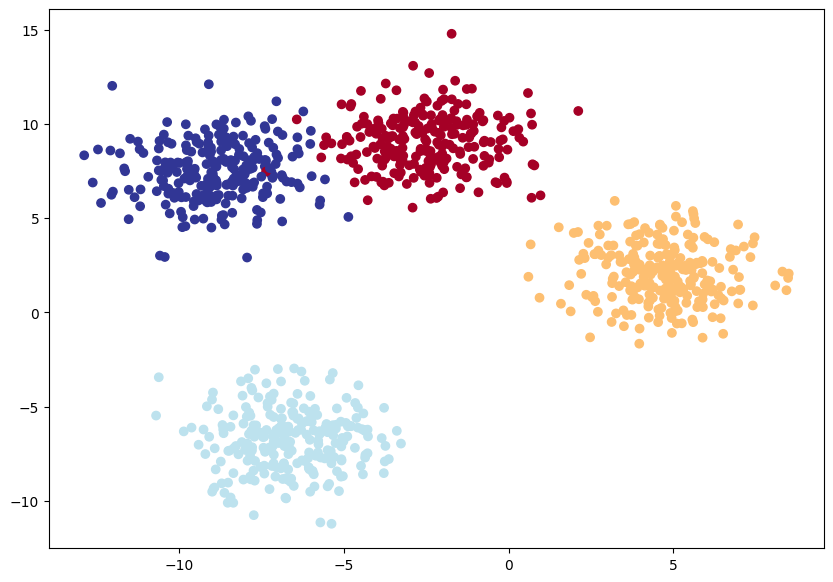

In [2]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn


# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors cuz make_blobs uses Numpy
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [3]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
             nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
             nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [7]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [8]:
X_blob_train.shape

torch.Size([800, 2])

In [9]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.2429, -0.7798, -1.1627,  0.1917],
        [ 0.4542, -2.2612, -0.9667,  0.6572],
        [-0.5079, -0.9494, -1.8736, -1.7532],
        [-0.1623, -0.7286, -1.1186, -0.8118],
        [ 0.4162, -1.8128, -0.5570,  0.5873]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [10]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [11]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2556, -0.9551, -1.3525,  0.2302],
        [ 0.0823, -1.6506, -0.2481,  0.1617],
        [-0.3665, -0.6813, -1.5701, -1.4132],
        [ 0.2777, -0.4559, -0.6406,  0.2241],
        [ 0.3947, -2.1771, -1.5448,  0.5576]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.4043, 0.1205, 0.0810, 0.3942],
        [0.3358, 0.0594, 0.2413, 0.3635],
        [0.4200, 0.3066, 0.1260, 0.1474],
        [0.3537, 0.1698, 0.1412, 0.3353],
        [0.4172, 0.0319, 0.0600, 0.4910]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [12]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [17]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[2])
print(torch.argmax(y_pred_probs[2]))

tensor([0.4200, 0.3066, 0.1260, 0.1474], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [19]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    def accuracy_fn(y_true, y_pred):
     correct = (y_pred == y_true).sum().item()
     acc = correct / len(y_true) * 100
     return acc

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.44999, Acc: 21.38% | Test Loss: 1.08413, Test Acc: 57.50%
Epoch: 10 | Loss: 0.34162, Acc: 98.75% | Test Loss: 0.29305, Test Acc: 99.00%
Epoch: 20 | Loss: 0.14936, Acc: 98.88% | Test Loss: 0.12823, Test Acc: 99.50%
Epoch: 30 | Loss: 0.09273, Acc: 98.88% | Test Loss: 0.07827, Test Acc: 99.50%
Epoch: 40 | Loss: 0.06922, Acc: 98.88% | Test Loss: 0.05704, Test Acc: 99.50%
Epoch: 50 | Loss: 0.05704, Acc: 98.75% | Test Loss: 0.04582, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04974, Acc: 98.88% | Test Loss: 0.03900, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04490, Acc: 99.00% | Test Loss: 0.03430, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04137, Acc: 99.00% | Test Loss: 0.03107, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03879, Acc: 99.00% | Test Loss: 0.02864, Test Acc: 99.50%


In [20]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  1.8775,   7.2550,  -5.6621, -10.1822],
        [  2.3374,  -8.7659,  -3.2986,   6.6750],
        [ -2.8795,  -3.5104,   5.5403,  -2.4986],
        [  0.3678,   4.5292,  -2.6227,  -5.4372],
        [  5.5808,   1.1053,  -8.8044,  -6.6956],
        [  2.4498, -10.2591,  -3.6834,   7.8732],
        [ -2.5843,  -2.4444,   4.8079,  -2.9561],
        [  4.8165,  -2.2695,  -6.9889,  -2.2256],
        [ -3.4837,  -4.5286,   6.6773,  -2.9924],
        [  5.0980,  -1.2063,  -7.5214,  -3.6219]], device='cuda:0')

In [21]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


In [23]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

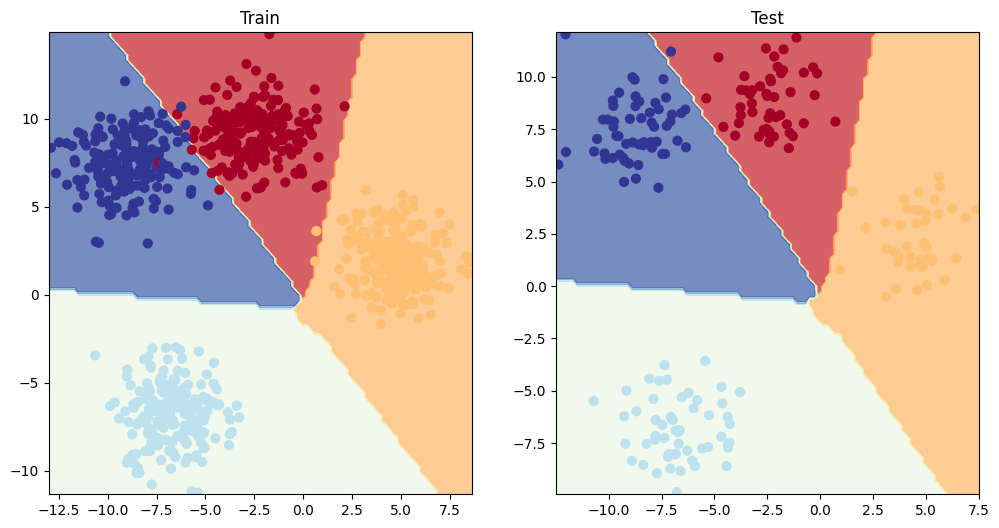

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)